## Forecasting Multiple Sites and Multiple Initialization Times

This notebok builds on [solar_example.ipynb](solar_example.ipynb) by forecasting multiple sites and then by running forecasts with multiple initialization times (i.e., intra-day forecasts produced every day for several days in a row).

Most of the time required to make a forecast is downloading the grib files, which cover the whole forecast region (global, in the case of GFS and IFS). Herbie's `pick_points` [1] then efficiently gets data from one or more points of interest. This means that forecasting many sites is only marginally slower than forecasting a single site. 

[1] https://herbie.readthedocs.io/en/2024.5.0/user_guide/tutorial/accessor_notebooks/pick_points.html

In [1]:
import matplotlib.pyplot as plt
from pv_model import model_pv_power
from forecast_solar import get_solar_forecast
import pandas as pd

In [2]:
# Define specs for 4 plants. Two tracking, two fixed-tilt. 
# This could also be stored in a csv or spreadsheet and read in as a dataframe.
plants_dict = {
    'latitude': [33.5, 33.8, 32.8, 32.1],
    'longitude': [-86.8, -84.4, -83.6, -81.1],
    'mount_type': ['single-axis', 'fixed', 'single-axis', 'fixed'],
    'gcr': [0.4, 0.6, 0.35, 0.35],
    'nameplate_dc': [120, 60, 100, 60],
    'nameplate_ac': [100, 50, 80, 50],
    'dc_loss_fraction': [0.1, 0.1, 0.2, 0.1],
    'gamma_pdc': [-0.003, -0.003, -0.003, -0.003],
    'shade_loss_model': ['linear', 'non-linear_simple_twin_module', 'non-linear_simple', 'non-linear_simple'],
    'backtrack': [False, None, True, None],
    'max_tracker_angle': [60, None, 50, None],
    'fixed_azimuth': [None, 180, None, 180],
    'fixed_tilt': [None, 20, None, 15],
}

# create a datafream
plants_df = pd.DataFrame(plants_dict)

# look at the dataframe
plants_df.head()

,latitude,longitude,mount_type,gcr,nameplate_dc,nameplate_ac,dc_loss_fraction,gamma_pdc,shade_loss_model,backtrack,max_tracker_angle,fixed_azimuth,fixed_tilt
0,33.5,-86.8,single-axis,0.40,120,100,0.1,-0.003,linear,False,60.0,NaN,NaN
1,33.8,-84.4,fixed,0.60,60,50,0.1,-0.003,non-linear_simple_twin_module,None,NaN,180.0,20.0
2,32.8,-83.6,single-axis,0.35,100,80,0.2,-0.003,non-linear_simple,True,50.0,NaN,NaN
3,32.1,-81.1,fixed,0.35,60,50,0.1,-0.003,non-linear_simple,None,NaN,180.0,15.0


In [3]:
# demonstrate getting specs for the first plant:
plants_df.loc[0].dropna().to_dict()

{'latitude': 33.5,
 'longitude': -86.8,
 'mount_type': 'single-axis',
 'gcr': 0.4,
 'nameplate_dc': 120,
 'nameplate_ac': 100,
 'dc_loss_fraction': 0.1,
 'gamma_pdc': -0.003,
 'shade_loss_model': 'linear',
 'backtrack': False,
 'max_tracker_angle': 60.0}

In [4]:
# get a forecast for all plants
latitudes = plants_df.latitude.values
longitudes = plants_df.longitude.values
num_sites = len(latitudes)

init_date = '2024-06-05 6:00'
resource_data = get_solar_forecast(
    latitude=latitudes,
    longitude=longitudes,
    init_date=init_date,
    run_length=18, # 18 hours are included in the forecast
    lead_time_to_start=3, # forecast starts 3 hours out from the init_date
    model='ifs',
)
resource_data['albedo'] = 0.2 # set a value for albedo

✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvsc_forecaster_2025\Lib\site-packages\herbie\core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.


In [5]:
# calculate power for each plant
power_dfs = {}
num_sites = len(plants_df.index)
for i in range(num_sites):
    plant_data_dict = plants_df.loc[i].dropna().to_dict()
    resource_data_temp = resource_data[resource_data['point']==i].copy()
    power_ac_expected, resource_data_updated = model_pv_power(
        resource_data=resource_data_temp,
        **plant_data_dict,
    )
    power_dfs[i] = power_ac_expected

<Axes: xlabel='valid_time'>

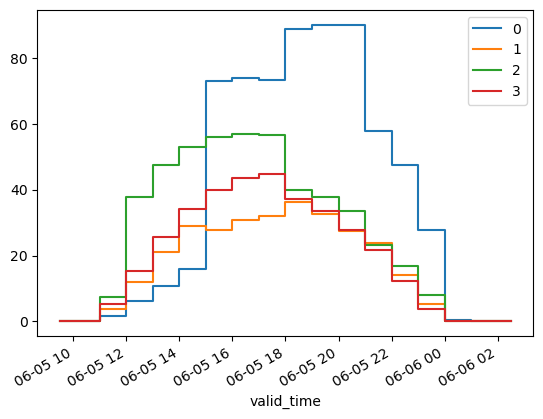

In [6]:
# plot
pd.concat(power_dfs,axis=1).plot(drawstyle='steps-mid')

In [7]:
# a range of initialization dates
dates = pd.date_range(start = '2024-06-05 6:00', end = '2024-06-08 6:00', freq = '1D')

dfs = []
for date in dates: # loop through dates
    resource_data_temp = get_solar_forecast(
        latitude=latitudes,
        longitude=longitudes,
        init_date=date, # <--
        run_length=18, # 18 hours are included in the forecast
        lead_time_to_start=3, # forecast starts 3 hours out from the init_date
        model='ifs',
    )
    dfs.append(resource_data_temp) # append
resource_data = pd.concat(dfs) # concatenate into one large dataframe
resource_data['albedo'] = 0.2 # fill in albedo data

✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws


c:\Users\willh\miniforge3\envs\pvsc_forecaster_2025\Lib\site-packages\herbie\core.py:1112: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-05 06:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-06 06:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=scda ┊ 2024-Jun-06 06:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
Note: Returning a list of [3] xarray.Datasets because cfgrib opened with multiple hyp

In [8]:
# calculate power for each plant
power_dfs = {}
num_sites = len(plants_df.index)
for i in range(num_sites):
    plant_data_dict = plants_df.loc[i].dropna().to_dict()
    resource_data_temp = resource_data[resource_data['point']==i].copy()
    power_ac_expected, resource_data_updated = model_pv_power(
        resource_data=resource_data_temp,
        **plant_data_dict,
    )
    power_dfs[i] = power_ac_expected

<Axes: xlabel='valid_time'>

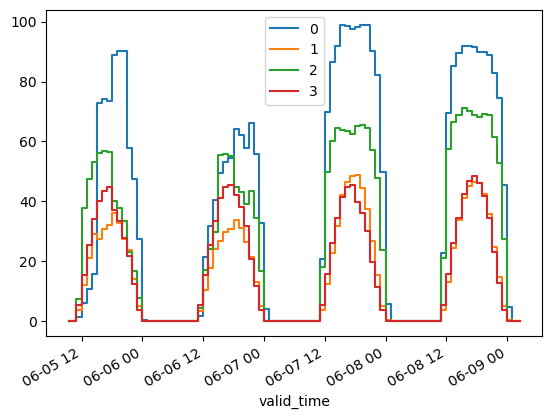

In [9]:
# plot
pd.concat(power_dfs,axis=1).plot(drawstyle='steps-mid')